<a href="https://colab.research.google.com/github/cdromcom/3actresearch/blob/master/study_3_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and require packages


Install packages to clean, explore, and analyze data.

In [11]:
install.packages("readr")
install.packages("readxl")
install.packages("tidyverse")
install.packages("ggpubr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’




In [3]:
install.packages("rstatix")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘data.table’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’




In [12]:
library(rstatix)
library(readr)
library(readxl)

library(tidyverse)
library(ggpubr)

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




# Clean and summarize data


Using an Excel (.xlsx) file.

In [0]:
s3ratings <- read_excel("/content/s3ratings.xlsx")

In [20]:
studythreeNew <- s3ratings %>%
  gather(key = "soundType", value = "rating", engine, whiteNoise, hum, horn, whistle, siren) %>%
  convert_as_factor(id, soundType)

summary(studythreeNew)

       id           soundType      rating     
 1      :  6   engine    :24   Min.   :0.000  
 2      :  6   horn      :24   1st Qu.:0.000  
 3      :  6   hum       :24   Median :1.000  
 4      :  6   siren     :24   Mean   :1.194  
 5      :  6   whistle   :24   3rd Qu.:2.000  
 6      :  6   whiteNoise:24   Max.   :4.000  
 (Other):108                                  

In [21]:
studythreeNew %>%
  group_by(soundType) %>%
  get_summary_stats(rating, type = "common")

soundType,variable,n,min,max,median,iqr,mean,sd,se,ci
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
engine,rating,24,0,3,2,1.25,1.958,0.999,0.204,0.422
horn,rating,24,0,4,0,0.00,0.583,1.213,0.248,0.512
hum,rating,24,0,4,1,1.00,1.500,1.103,0.225,0.466
siren,rating,24,0,2,0,1.00,0.583,0.776,0.158,0.327
whistle,rating,24,0,4,1,1.25,0.958,1.083,0.221,0.457
whiteNoise,rating,24,0,4,2,1.00,1.583,1.100,0.225,0.465


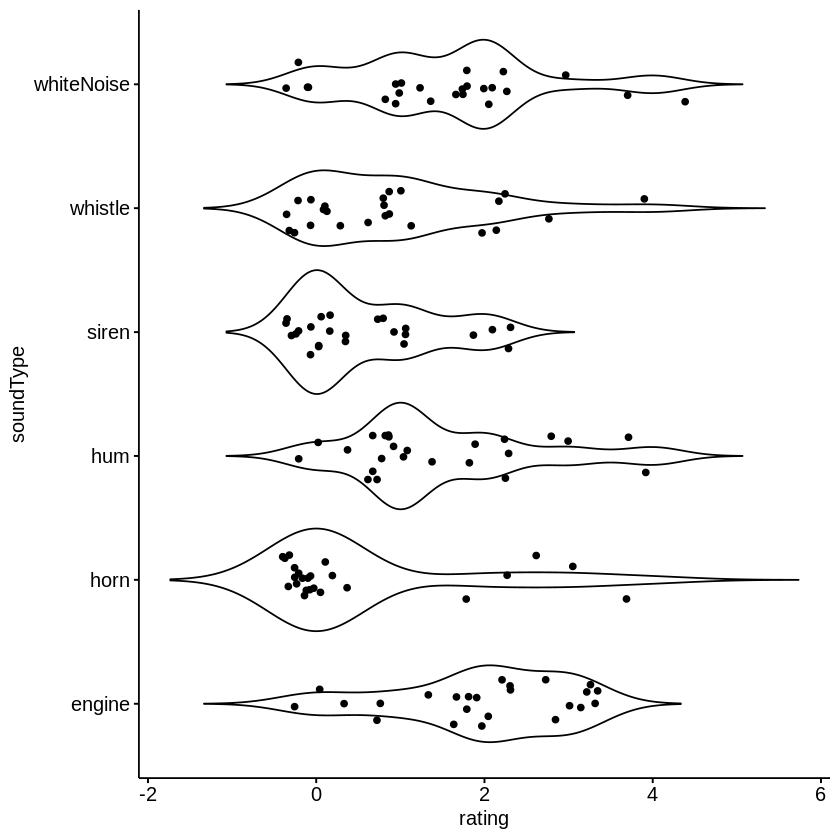

In [31]:
ggviolin(studythreeNew, x = "soundType", y = "rating", add = "jitter")+
  coord_flip()

In [32]:
shapiro_test(studythreeNew, rating)

variable,statistic,p
<chr>,<dbl>,<dbl>
rating,0.8540663,1.244779e-10


Shapiro test is statistically significant. Normality assumption is violated.

# Friedman test and post-hoc analyses

For a non-parametric version of an RM ANOVA, the Friedman test is appropriate.

In [34]:
res.fried <- studythreeNew %>% friedman_test(rating ~ soundType |id)

res.fried

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,rating,24,74.12972,5,1.413179e-14,Friedman test


Calculate the effect size (moderate-to-large here).

In [36]:
studythreeNew %>% friedman_effsize(rating ~ soundType |id, ci = TRUE, conf.level = 0.99, ci.type = "perc", nboot = 1000)

,.y.,n,effsize,conf.low,conf.high,method,magnitude
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<ord>
1,rating,24,0.6177477,0.43,0.8,Kendall W,large


Conduct post-hoc analyses using the Wilcoxon test and adjust p-values using the Bonferroni procedure.


In [37]:
pwc <- studythreeNew %>%
  wilcox_test(rating ~ soundType, paired = TRUE, p.adjust.method = "bonferroni")

pwc

,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,rating,engine,horn,24,24,186.5,1.84e-04,0.003000,**
2,rating,engine,hum,24,24,104.0,5.00e-03,0.075000,ns
3,rating,engine,siren,24,24,231.0,3.70e-05,0.000555,***
4,rating,engine,whistle,24,24,202.5,1.53e-04,0.002000,**
5,rating,engine,whiteNoise,24,24,77.0,1.40e-02,0.210000,ns
6,rating,horn,hum,24,24,0.0,8.69e-05,0.001000,**
7,rating,horn,siren,24,24,22.5,1.00e+00,1.000000,ns
8,rating,horn,whistle,24,24,5.0,1.50e-02,0.220000,ns
9,rating,horn,whiteNoise,24,24,0.0,3.27e-04,0.005000,**


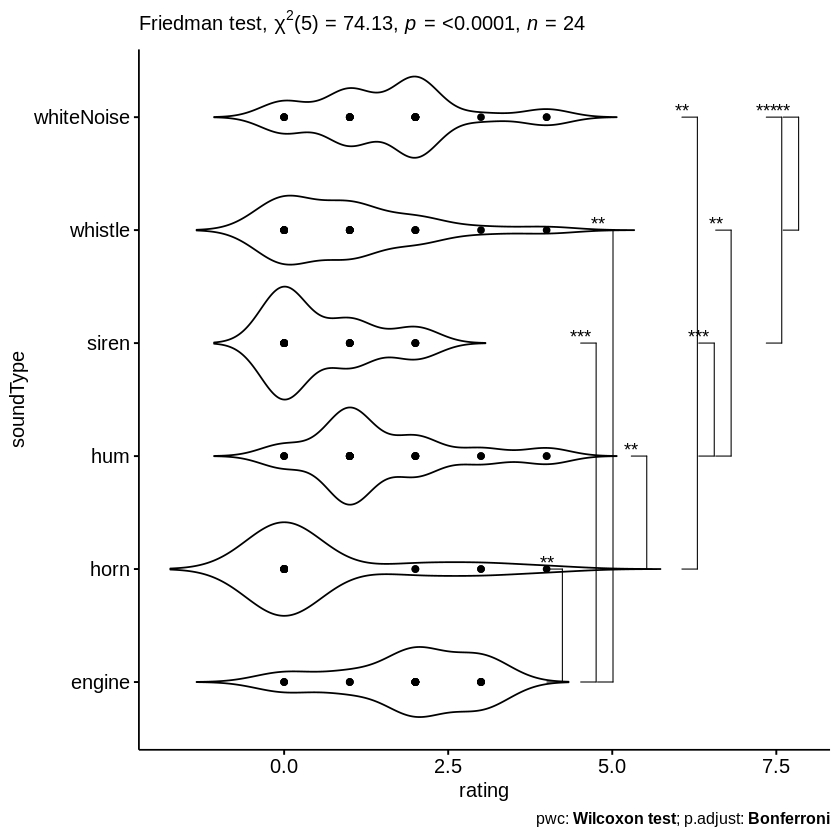

In [42]:
pwc <- pwc %>% add_xy_position(x = "time")
ggviolin(studythreeNew, x = "soundType", y = "rating", add = "point") +
  stat_pvalue_manual(pwc, hide.ns = TRUE) +
  coord_flip()+
  labs(
    subtitle = get_test_label(res.fried, detailed = TRUE),
    caption = get_pwc_label(pwc)
  )

# Power and Sensitivity Analyses

The "retrodesign" package from [R CRAN](https://cran.r-project.org/web/packages/retrodesign/index.html) implements the calculation of Type S and Type M errors as advised by [Gelman and Carlin, 2014](https://cran.r-project.org/web/packages/retrodesign/vignettes/Intro_To_retrodesign.html).

In [40]:
# Type S and Type M Error Analysis
install.packages("retrodesign")
library(retrodesign)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Compute Type S and Type M errors for effect sizes ranging from .20 to 1.0. SE from the post-hoc analyses above is around 0.06.

In [41]:
errors <- retro_design(list(.20,.30,.40,.50, .60),0.20)

errors

effect_size,power,type_s,type_m
<list>,<list>,<list>,<list>
0.2,0.170075,0.009045272,2.490928
0.3,0.3230412,0.0008361901,1.741059
0.4,0.5160053,7.263595e-05,1.386265
0.5,0.705418,5.810273e-06,1.195521
0.6,0.8508388,4.143338e-07,1.091004
